In [10]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
from math import pi
import os
from prophet import Prophet

c:\Users\Arnav Waghdhare\Desktop\Arnav20\Coding\Python\case-study\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [5]:
def load_all_csv_files(data_dir='data') -> dict:
    dataframes = {}
    
    # Get all CSV files in the directory
    csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    
    # Read each CSV file
    for csv_file in csv_files:
        file_path = os.path.join(data_dir, csv_file)
        # Use filename without extension as dictionary key
        file_key = csv_file.replace('.csv', '')
        dataframes[file_key] = pd.read_csv(file_path)
        print(f"Loaded {csv_file}: {dataframes[file_key].shape[0]} rows, {dataframes[file_key].shape[1]} columns")
    
    return dataframes

In [6]:
dfs = load_all_csv_files('data')

Loaded Assamese_songs.csv: 724 rows, 19 columns
Loaded Bengali_songs.csv: 958 rows, 19 columns
Loaded Bhojpuri_songs.csv: 519 rows, 19 columns
Loaded Gujarati_songs.csv: 2115 rows, 19 columns
Loaded Haryanvi_songs.csv: 228 rows, 19 columns
Loaded Hindi_songs.csv: 1184 rows, 19 columns
Loaded Kannada_songs.csv: 3559 rows, 19 columns
Loaded Malayalam_songs.csv: 479 rows, 19 columns
Loaded Marathi_songs.csv: 4699 rows, 19 columns
Loaded Odia_songs.csv: 940 rows, 19 columns
Loaded Old_songs.csv: 2448 rows, 19 columns
Loaded Punjabi_songs.csv: 3818 rows, 19 columns
Loaded Rajasthani_songs.csv: 541 rows, 19 columns
Loaded spotify_data clean.csv: 8582 rows, 15 columns
Loaded Tamil_songs.csv: 4677 rows, 19 columns
Loaded Telugu_songs.csv: 4996 rows, 19 columns
Loaded Urdu_songs.csv: 3116 rows, 19 columns


In [12]:
# Prepare time series data for Prophet
# Aggregate popularity by language and date

def prepare_language_timeseries(dfs, language_key):
    """
    Prepare time series data for a specific language
    Returns DataFrame with 'ds' (date) and 'y' (popularity score)
    """
    if language_key not in dfs:
        return None
    
    df = dfs[language_key].copy()
    
    # Convert released_date to datetime
    df['released_date'] = pd.to_datetime(df['released_date'], format='%d-%m-%Y', errors='coerce')
    
    # Drop rows with invalid dates
    df = df.dropna(subset=['released_date'])
    
    # Group by month and calculate average popularity
    df['year_month'] = df['released_date'].dt.to_period('M')
    monthly_data = df.groupby('year_month').agg({
        'popularity': 'mean',
        'Stream': 'sum'
    }).reset_index()
    
    # Convert period back to timestamp
    monthly_data['ds'] = monthly_data['year_month'].dt.to_timestamp()
    monthly_data['y'] = monthly_data['popularity']
    
    # Select only required columns for Prophet
    prophet_df = monthly_data[['ds', 'y']].sort_values('ds')
    
    return prophet_df

# Get major Indian languages (excluding 'Old_songs' and 'spotify_data clean')
major_languages = [
    'Hindi', 'Tamil', 'Telugu', 'Punjabi', 'Bengali', 
    'Kannada', 'Malayalam', 'Marathi', 'Gujarati', 'Urdu'
]

# Prepare data for all languages
language_data = {}
for lang in major_languages:
    lang_key = f"{lang}_songs"
    ts_data = prepare_language_timeseries(dfs, lang_key)
    if ts_data is not None and len(ts_data) > 10:  # Need sufficient data points
        language_data[lang] = ts_data
        print(f"Prepared {lang}: {len(ts_data)} data points from {ts_data['ds'].min()} to {ts_data['ds'].max()}")

print(f"\nTotal languages with sufficient data: {len(language_data)}")

Prepared Hindi: 283 data points from 2000-01-01 00:00:00 to 2024-04-01 00:00:00
Prepared Tamil: 292 data points from 2000-01-01 00:00:00 to 2024-04-01 00:00:00
Prepared Telugu: 292 data points from 2000-01-01 00:00:00 to 2024-04-01 00:00:00
Prepared Punjabi: 292 data points from 2000-01-01 00:00:00 to 2024-04-01 00:00:00
Prepared Bengali: 273 data points from 2000-01-01 00:00:00 to 2024-04-01 00:00:00
Prepared Kannada: 292 data points from 2000-01-01 00:00:00 to 2024-04-01 00:00:00
Prepared Malayalam: 232 data points from 2000-01-01 00:00:00 to 2024-04-01 00:00:00
Prepared Marathi: 292 data points from 2000-01-01 00:00:00 to 2024-04-01 00:00:00
Prepared Gujarati: 290 data points from 2000-01-01 00:00:00 to 2024-04-01 00:00:00
Prepared Urdu: 292 data points from 2000-01-01 00:00:00 to 2024-04-01 00:00:00

Total languages with sufficient data: 10


In [13]:
# Build Prophet models and forecast for each language
forecasts = {}
models = {}

# Forecast for next 3 years (36 months)
forecast_periods = 36

for lang, data in language_data.items():
    print(f"\nTraining Prophet model for {lang}...")
    
    # Initialize and fit the model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05
    )
    
    model.fit(data)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=forecast_periods, freq='MS')
    
    # Make predictions
    forecast = model.predict(future)
    
    # Store results
    models[lang] = model
    forecasts[lang] = forecast
    
    print(f"{lang}: Model trained. Forecast from {forecast['ds'].min()} to {forecast['ds'].max()}")

print(f"\nCompleted forecasting for {len(forecasts)} languages")


Training Prophet model for Hindi...


14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:30 - cmdstanpy - INFO - Chain [1] done processing
14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:31 - cmdstanpy - INFO - Chain [1] done processing


Hindi: Model trained. Forecast from 2000-01-01 00:00:00 to 2027-04-01 00:00:00

Training Prophet model for Tamil...
Tamil: Model trained. Forecast from 2000-01-01 00:00:00 to 2027-04-01 00:00:00

Training Prophet model for Telugu...


14:19:31 - cmdstanpy - INFO - Chain [1] start processing
14:19:31 - cmdstanpy - INFO - Chain [1] done processing
14:19:31 - cmdstanpy - INFO - Chain [1] start processing
14:19:31 - cmdstanpy - INFO - Chain [1] done processing


Telugu: Model trained. Forecast from 2000-01-01 00:00:00 to 2027-04-01 00:00:00

Training Prophet model for Punjabi...


14:19:31 - cmdstanpy - INFO - Chain [1] start processing
14:19:31 - cmdstanpy - INFO - Chain [1] done processing


Punjabi: Model trained. Forecast from 2000-01-01 00:00:00 to 2027-04-01 00:00:00

Training Prophet model for Bengali...
Bengali: Model trained. Forecast from 2000-01-01 00:00:00 to 2027-04-01 00:00:00

Training Prophet model for Kannada...


14:19:31 - cmdstanpy - INFO - Chain [1] start processing
14:19:31 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing


Kannada: Model trained. Forecast from 2000-01-01 00:00:00 to 2027-04-01 00:00:00

Training Prophet model for Malayalam...


14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing


Malayalam: Model trained. Forecast from 2000-01-01 00:00:00 to 2027-04-01 00:00:00

Training Prophet model for Marathi...
Marathi: Model trained. Forecast from 2000-01-01 00:00:00 to 2027-04-01 00:00:00

Training Prophet model for Gujarati...


14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing


Gujarati: Model trained. Forecast from 2000-01-01 00:00:00 to 2027-04-01 00:00:00

Training Prophet model for Urdu...
Urdu: Model trained. Forecast from 2000-01-01 00:00:00 to 2027-04-01 00:00:00

Completed forecasting for 10 languages


In [14]:
# Summary statistics: Average predicted popularity for next 2-3 years by language
summary_data = []

for lang, forecast in forecasts.items():
    last_actual_date = language_data[lang]['ds'].max()
    future_forecast = forecast[forecast['ds'] > last_actual_date]
    
    # Calculate statistics for the forecast period
    avg_popularity = future_forecast['yhat'].mean()
    min_popularity = future_forecast['yhat'].min()
    max_popularity = future_forecast['yhat'].max()
    trend = future_forecast['yhat'].iloc[-1] - future_forecast['yhat'].iloc[0]
    
    summary_data.append({
        'Language': lang,
        'Avg Predicted Popularity': round(avg_popularity, 2),
        'Min Predicted': round(min_popularity, 2),
        'Max Predicted': round(max_popularity, 2),
        'Overall Trend': round(trend, 2),
        'Trend Direction': 'Increasing' if trend > 0 else 'Decreasing'
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Avg Predicted Popularity', ascending=False)

print("\n" + "="*80)
print("FORECAST SUMMARY: Average Popularity Scores for Next 2-3 Years (2026-2029)")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)


FORECAST SUMMARY: Average Popularity Scores for Next 2-3 Years (2026-2029)
 Language  Avg Predicted Popularity  Min Predicted  Max Predicted  Overall Trend Trend Direction
 Gujarati                     63.97          60.76          66.66           1.48      Increasing
  Punjabi                     63.65          59.72          67.23           0.35      Increasing
  Kannada                     63.01          58.32          66.71           2.27      Increasing
    Tamil                     62.71          59.79          67.06           1.48      Increasing
  Bengali                     62.68          59.39          70.12           0.56      Increasing
   Telugu                     62.39          59.62          64.56           0.54      Increasing
  Marathi                     62.34          59.55          64.81          -4.79      Decreasing
     Urdu                     61.97          59.71          64.48           2.26      Increasing
    Hindi                     61.77          56.14 

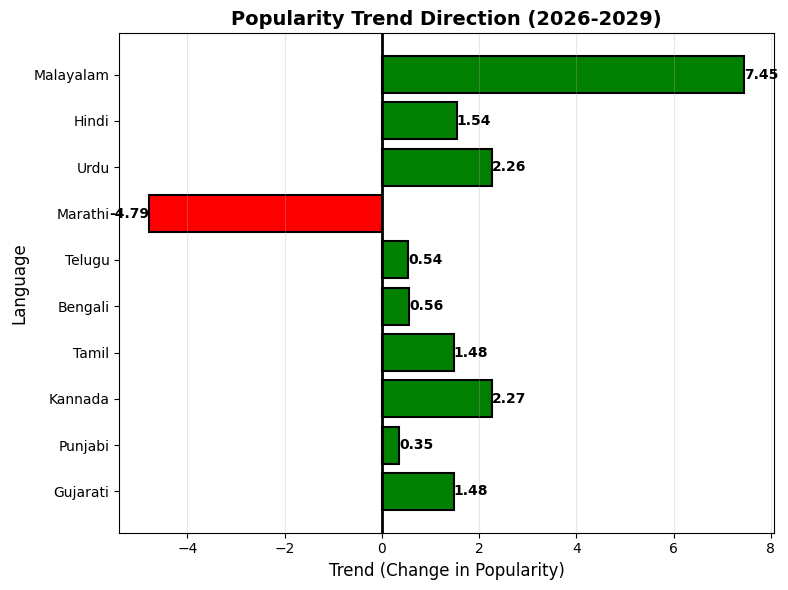

In [19]:
# Trend direction visualization
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

# Plot 1: Trend direction with colors
trend_colors = ['green' if x > 0 else 'red' for x in summary_df['Overall Trend']]
bars1 = ax1.barh(summary_df['Language'], summary_df['Overall Trend'], 
                 color=trend_colors, edgecolor='black', linewidth=1.5)

for idx, (bar, trend) in enumerate(zip(bars1, summary_df['Overall Trend'])):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2.,
             f'{trend:.2f}',
             ha='left' if width > 0 else 'right', 
             va='center', fontsize=10, fontweight='bold')

ax1.axvline(x=0, color='black', linewidth=2)
ax1.set_xlabel('Trend (Change in Popularity)', fontsize=12)
ax1.set_ylabel('Language', fontsize=12)
ax1.set_title('Popularity Trend Direction (2026-2029)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

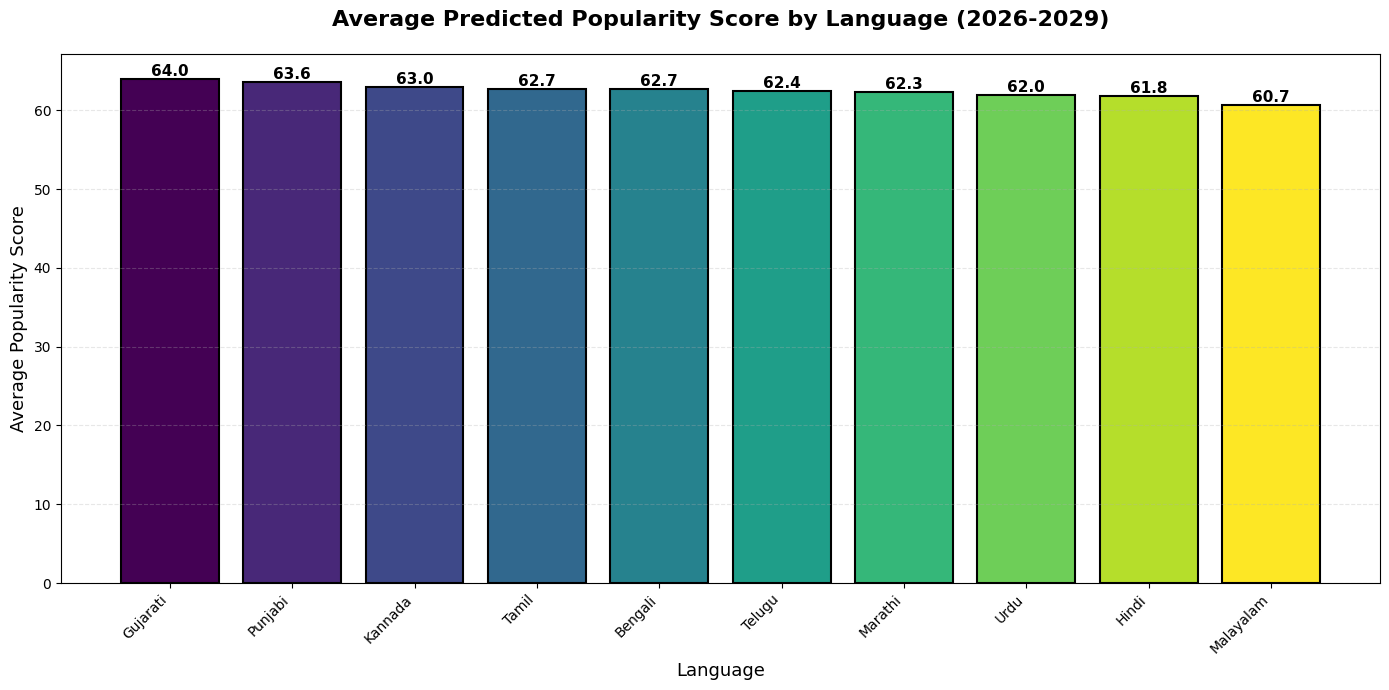

In [16]:
# Bar chart: Average predicted popularity by language
plt.figure(figsize=(14, 7))

colors = plt.cm.viridis(np.linspace(0, 1, len(summary_df)))
bars = plt.bar(summary_df['Language'], summary_df['Avg Predicted Popularity'], 
               color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Average Predicted Popularity Score by Language (2026-2029)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Language', fontsize=13)
plt.ylabel('Average Popularity Score', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

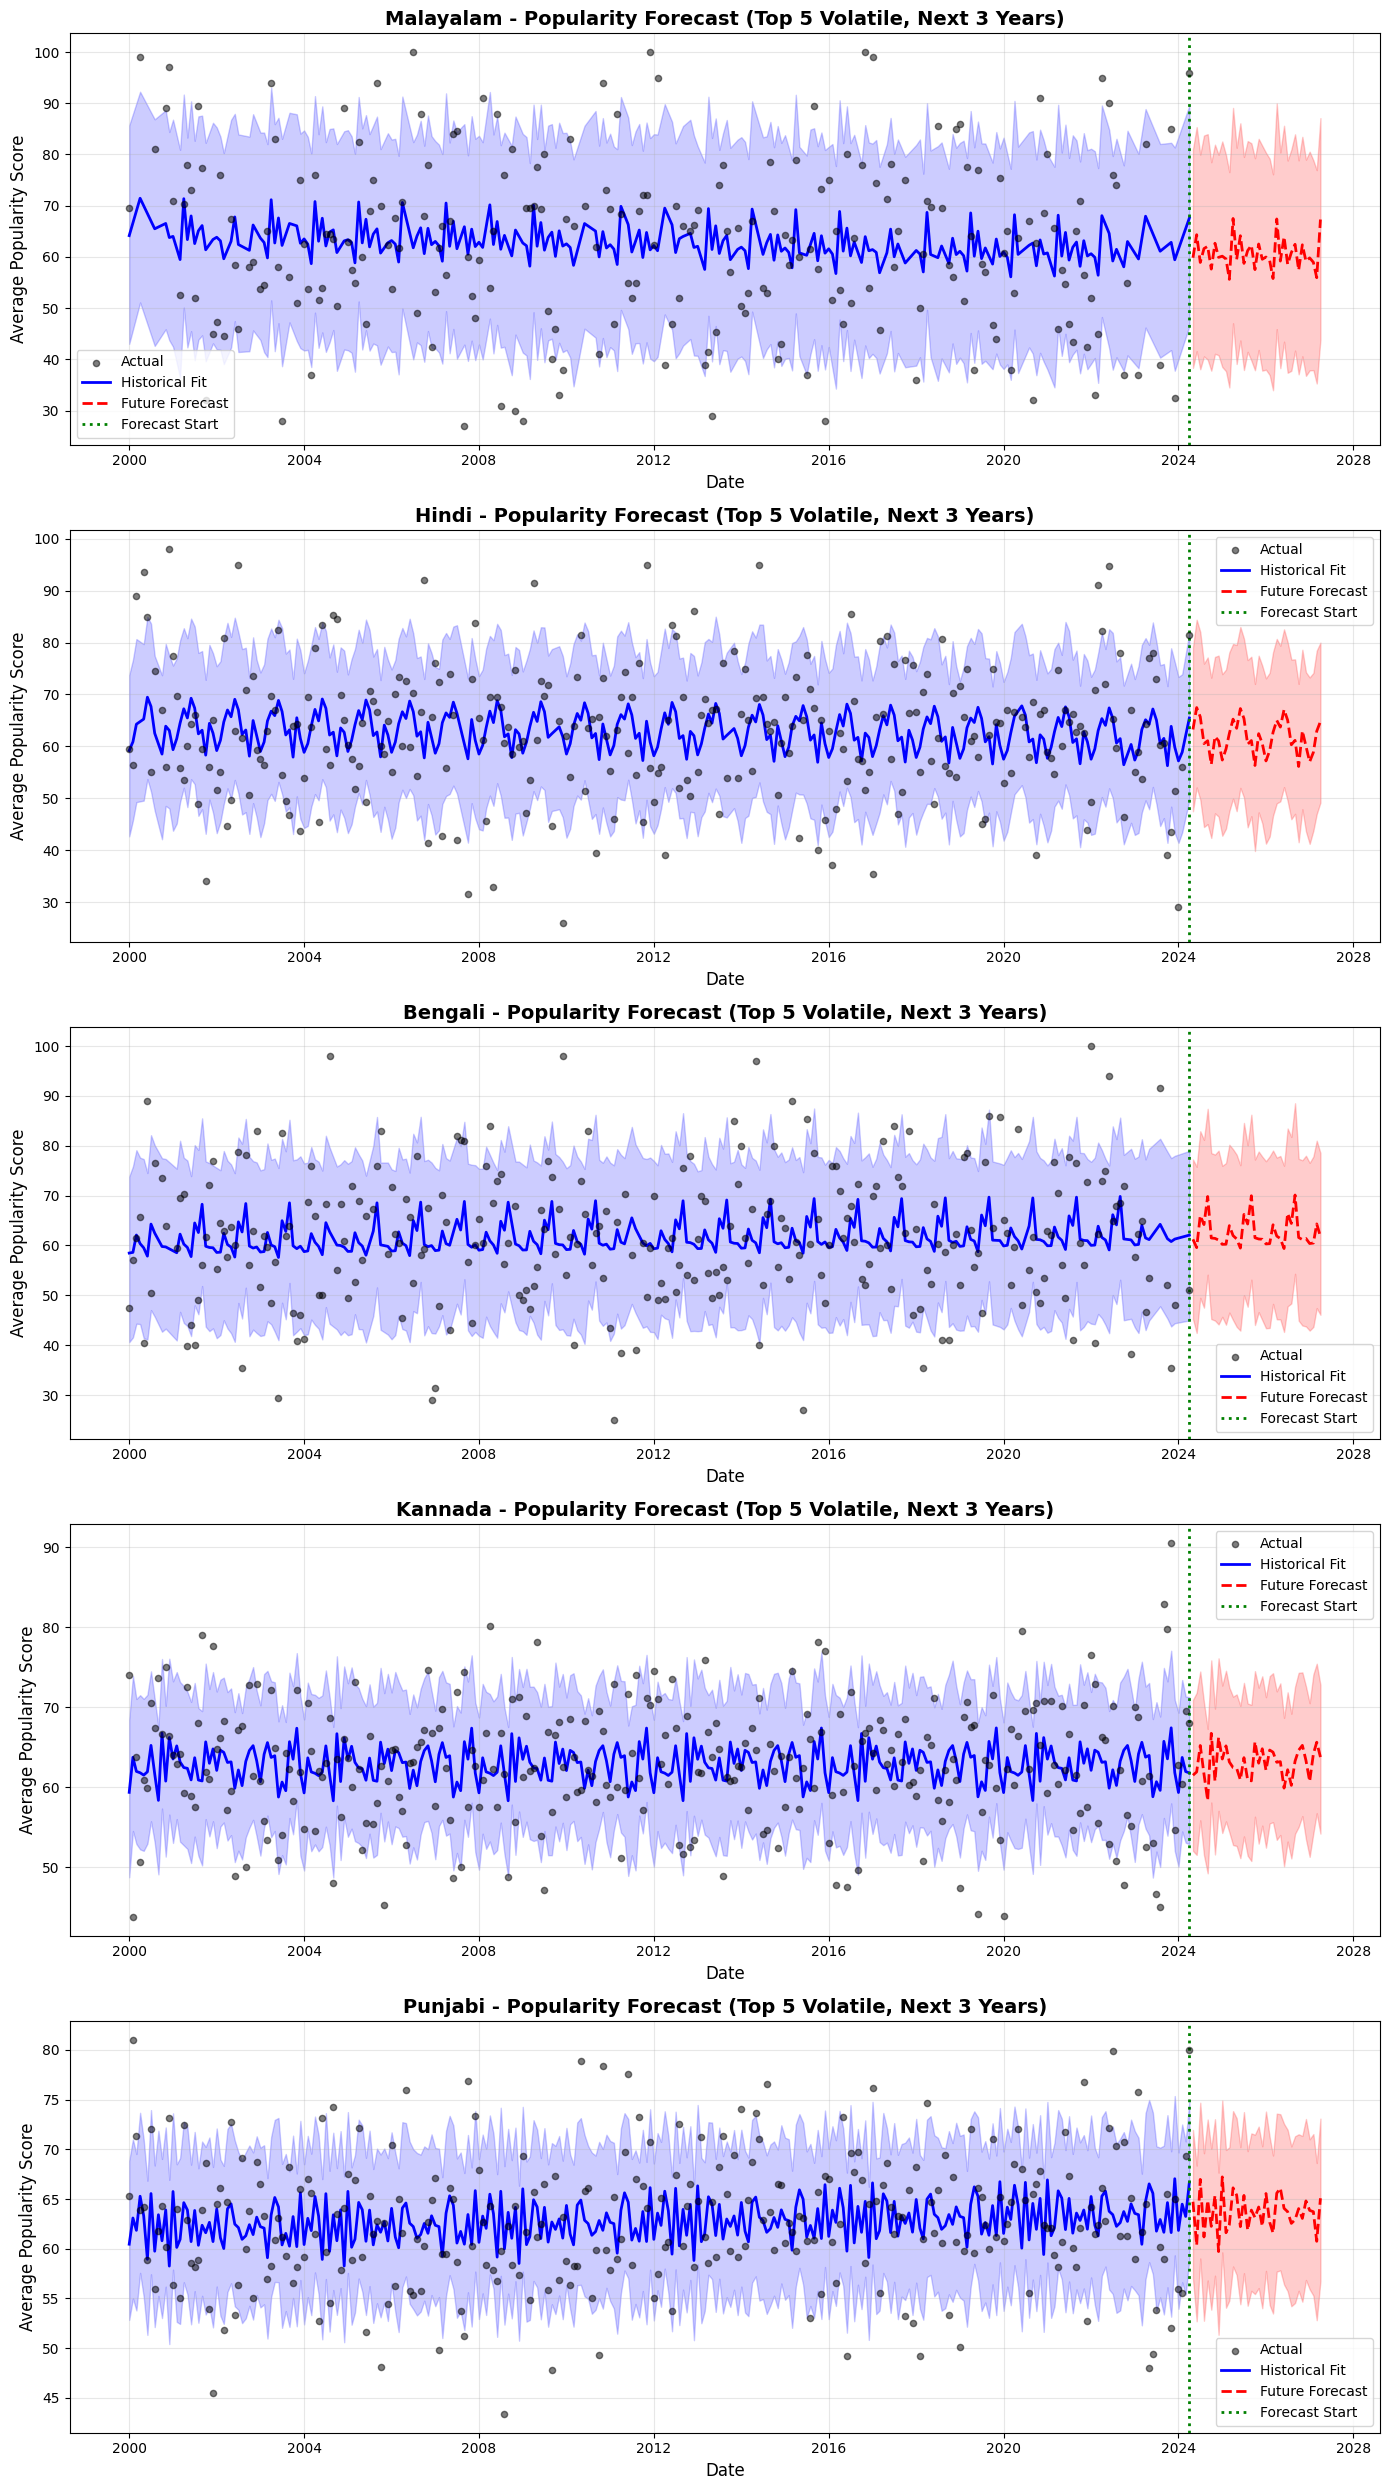

In [21]:
# Plot forecast for each language individually (top 5 most volatile)
volatility_summary = []

for lang, forecast in forecasts.items():
    last_actual_date = language_data[lang]['ds'].max()
    future = forecast[forecast['ds'] > last_actual_date]
    if len(future) == 0:
        continue
    volatility = future['yhat'].max() - future['yhat'].min()
    volatility_summary.append((lang, volatility))

top_5_volatile = [lang for lang, _ in sorted(volatility_summary, key=lambda x: x[1], reverse=True)[:5]]

fig, axes = plt.subplots(len(top_5_volatile), 1, figsize=(14, 5*len(top_5_volatile)))

if len(top_5_volatile) == 1:
    axes = [axes]

for idx, lang in enumerate(top_5_volatile):
    forecast = forecasts[lang]
    ax = axes[idx]
    
    # Get actual data
    actual_data = language_data[lang]
    
    # Split forecast into historical and future
    last_actual_date = actual_data['ds'].max()
    historical = forecast[forecast['ds'] <= last_actual_date]
    future = forecast[forecast['ds'] > last_actual_date]
    
    # Plot actual data
    ax.scatter(actual_data['ds'], actual_data['y'], 
               color='black', s=20, alpha=0.5, label='Actual', zorder=3)
    
    # Plot historical forecast
    ax.plot(historical['ds'], historical['yhat'], 
            color='blue', linewidth=2, label='Historical Fit')
    ax.fill_between(historical['ds'], 
                     historical['yhat_lower'], 
                     historical['yhat_upper'],
                     alpha=0.2, color='blue')
    
    # Plot future forecast
    ax.plot(future['ds'], future['yhat'], 
            color='red', linewidth=2, linestyle='--', label='Future Forecast')
    ax.fill_between(future['ds'], 
                     future['yhat_lower'], 
                     future['yhat_upper'],
                     alpha=0.2, color='red')
    
    # Add vertical line at prediction start
    ax.axvline(x=last_actual_date, color='green', 
               linestyle=':', linewidth=2, label='Forecast Start')
    
    ax.set_title(f'{lang} - Popularity Forecast (Top 5 Volatile, Next 3 Years)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Average Popularity Score', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()